## Final Project
### Authors: Naat Ambrosino, Jerrin Redmon
### Version: 1
### Semester: Spring 2022

### Information from Dataset Source:
#### Data Set Information:
##### This data set contains some training and testing data from a remote sensing study by Johnson et al. (2013) that involved detecting diseased trees in Quickbird imagery. There are few training samples for the 'diseased trees' class (74) and many for 'other land cover' class (4265).

##### The data set consists of image segments, generated by segmenting the pansharpened image. The segments contain spectral information from the Quickbird multispectral image bands and texture information from the panchromatic (Pan) image band. The testing data set is for the row with â€œSegmentation scale 15â€ segments and â€œoriginal multi-spectral imageâ€ Spectral information in Table 2 of the reference (i.e. row 5). Please see the reference below for more information on the data set, and please cite the reference if you use this data set. Enjoy!

##### Files
##### training.csv: training data set (4339 image segments)
##### testing.csv: testing data set (500 image segments)


#### Attribute Information:

##### class: 'w' (diseased trees), 'n' (all other land cover)
##### GLCM_Pan: GLCM mean texture (Pan band)
##### Mean_G: Mean green value
##### Mean_R: Mean red value
##### Mean_NIR: Mean NIR value (NIR means near infrared)
##### SD_Pan: Standard deviation (Pan band)



### Summary:
#### The dataset was made because some people were trying to detect disesased trees via arial photos (and then making a program that could 'see' the diseased trees in the photos. The data is different aspects of the image(s). 

Importing packages and reading in .csv files

In [424]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#From Logistic regression file
from sklearn.linear_model import LogisticRegression

In [333]:
dtesting=pd.read_csv("testing.csv")
dtraining=pd.read_csv("training.csv")

It seems like the dataset creators preemptively split the data into a training and testing set, just by looking at the CSV files proper and from the description from the site. I am going to combine them back into one dataframe for the exploratory analysis, then take new random samples once we begin the Machine Learning portion.

In [334]:
#dtesting

In [335]:
#dtraining

In [336]:
df=pd.concat([dtesting,dtraining],ignore_index=True,sort=False)

In [337]:
df

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,n,109.828571,183.700000,82.950000,251.750000,16.079412
1,n,130.284483,212.637931,96.896552,482.396552,21.210295
2,n,131.386555,185.466667,85.466667,419.666667,13.339998
3,n,141.345098,180.875000,81.500000,348.062500,18.213577
4,w,121.383408,218.357143,112.017857,426.607143,19.083196
...,...,...,...,...,...,...
4834,n,111.568773,203.588235,93.264706,403.735294,26.512777
4835,n,125.435240,206.394161,93.058394,512.270073,33.466060
4836,n,132.123859,465.343750,295.333333,499.250000,38.762967
4837,n,124.469536,215.152632,98.484211,675.915789,28.506542


Now to get basic statistical information about the dataset using .describe().

In [338]:
df.describe() #Note, this is before we drop the Triple Major Outlier

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
count,4839.000000,4839.000000,4839.000000,4839.000000,4839.000000
mean,126.855547,231.412658,116.305331,525.800301,24.482007
std,13.450516,63.264941,62.005622,156.579297,10.726997
min,0.000000,117.210526,50.578947,86.500000,0.000000
25%,118.758944,203.896429,91.527009,415.448161,17.679972
50%,127.481872,219.260870,101.631579,518.657143,23.198396
75%,134.947789,239.860577,116.969687,635.133450,29.326445
max,183.281250,1848.916667,1594.583333,1597.333333,156.508431


Checking for null values using .info(). Notice that there are 4839 entries, and 4839 non-null entries for each column. Thus, there are no missing values. Next task will be to check for outliers.

In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4839 entries, 0 to 4838
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   class       4839 non-null   object 
 1   GLCM_pan    4839 non-null   float64
 2   Mean_Green  4839 non-null   float64
 3   Mean_Red    4839 non-null   float64
 4   Mean_NIR    4839 non-null   float64
 5   SD_pan      4839 non-null   float64
dtypes: float64(5), object(1)
memory usage: 227.0+ KB


First, let's use boxplots to look for outliers. sns.boxplot defaults to outliers being 150% of the IQR outside of Q1 and Q3.

<AxesSubplot:>

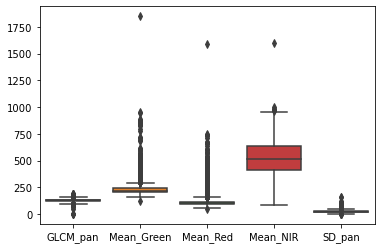

In [340]:
sns.boxplot(data=df)

Note that the ranges for GLCM_pan and SD_pan are much smaller than the Means' ranges. Also, more relevantly, note there are a lot of outliers. Going to extend the whiskers so that outliers are 300% of the IQR outside of Q1 and Q3, and see if that changes things much.

<AxesSubplot:>

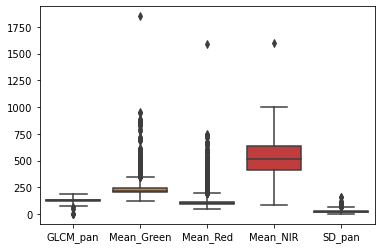

In [341]:
sns.boxplot(data=df, whis=3)

Extending the whiskers did not do much. The values all seem to be very skewed, if not multimodal. (Also, note those 3 points near the top of the chart, far removed from the rest of the data. As we investigate the outliers, we will find that all three of those data points belong to a single entry, index 479, occasionally referred to as the Triple Major Outlier, which will be removed shortly.)

Going to make histograms of the data to look at the distributions of the columns' values before we begin looking at individual outliers, just to get a better idea of whats going on before we start removing entries.

In [342]:
# Basic guide to multiplots
#fig, axes = plt.subplots(2,2, figsize=(12,7))
#re50.plot(kind='area',xlabel='Time of Day',ylabel='TW/h Generated', title=f'Power Production: 50Hertz/2019-08-24',color='red',legend=False,ax=axes[0,0])
#reAm.plot(kind='area',xlabel='Time of Day',ylabel='TW/h Generated', title=f'Power Production: Amprion/2019-08-24',color='green',legend=False,ax=axes[0,1])
#reTe.plot(kind='area',xlabel='Time of Day',ylabel='TW/h Generated', title=f'Power Production: TenneTTSO/2019-08-24',color='blue',legend=False,ax=axes[1,0])
#reTr.plot(kind='area',xlabel='Time of Day',ylabel='TW/h Generated', title=f'Power Production: TransnetBW/2019-08-24',color='purple',legend=False,ax=axes[1,1])
#fig.tight_layout(pad=3)
#Basic guide to histograms
#plt.hist(dia.price, bins=50)

(array([  4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   3.,   4.,   0.,
          5.,  16.,  14.,  24.,  42.,  48.,  90., 140., 242., 387., 478.,
        483., 569., 569., 614., 434., 270., 156.,  93.,  49.,  37.,  19.,
         18.,  13.,   4.,   3.,   1.,   8.]),
 array([  0.      ,   3.665625,   7.33125 ,  10.996875,  14.6625  ,
         18.328125,  21.99375 ,  25.659375,  29.325   ,  32.990625,
         36.65625 ,  40.321875,  43.9875  ,  47.653125,  51.31875 ,
         54.984375,  58.65    ,  62.315625,  65.98125 ,  69.646875,
         73.3125  ,  76.978125,  80.64375 ,  84.309375,  87.975   ,
         91.640625,  95.30625 ,  98.971875, 102.6375  , 106.303125,
        109.96875 , 113.634375, 117.3     , 120.965625, 124.63125 ,
        128.296875, 131.9625  , 135.628125, 139.29375 , 142.959375,
        146.625   , 150.290625, 153.95625 , 157.621875, 161.2875  ,
        164.953125, 168.61875 , 172.284375, 17

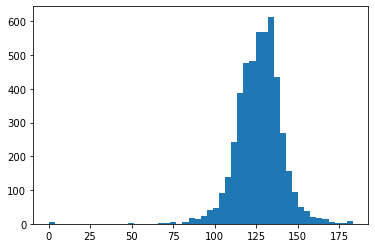

In [343]:
plt.hist(df.GLCM_pan, bins=50)

First, made the histogram of GLCM_pan. It is definitely unimodal, with a slight left skew. Now, going to look closer at the boxplot.

<AxesSubplot:>

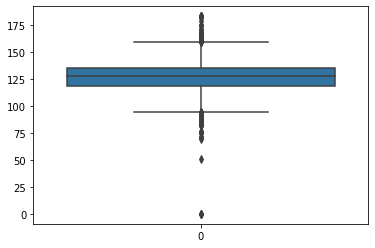

In [344]:
sns.boxplot(data=df.GLCM_pan)

Note how far the values close to 0 are away from all other datapoints. Going to query the dataframe to find out the indices of those, along with the one point around 50.

In [345]:
findGLCMpan=df.query('GLCM_pan<60')
findGLCMpan

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
1482,n,0.0,450.0,279.0,592.0,0.0
1493,n,0.0,313.0,207.0,416.0,0.0
1515,n,0.0,328.0,223.0,384.0,0.0
1545,n,51.0,346.0,217.0,376.0,0.0
2813,n,0.0,336.0,190.0,579.0,0.0


Those really far outliers in GLCM_pan are 1482, 1493, 1515, and 2813. Note that for each of those, both GLCM_pan and SD_pan are 0. The less eggrevious value was at GLCM_pan=51, and it is index 1545. Note that SD_pan is 0 for that as well.

Now to look at SD_pan. Going a bit out of order, but SD_pan and GLCM_pan have similar ranges, and their major outliers may be connected. First, histogram.

(array([ 12.,  16., 104., 246., 431., 643., 682., 705., 593., 484., 325.,
        210., 129.,  82.,  52.,  32.,  21.,  14.,   8.,   9.,   4.,   1.,
          6.,   3.,   4.,   6.,   3.,   2.,   1.,   0.,   1.,   1.,   3.,
          3.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.]),
 array([  0.        ,   3.13016861,   6.26033723,   9.39050584,
         12.52067446,  15.65084307,  18.78101168,  21.9111803 ,
         25.04134891,  28.17151753,  31.30168614,  34.43185475,
         37.56202337,  40.69219198,  43.8223606 ,  46.95252921,
         50.08269782,  53.21286644,  56.34303505,  59.47320367,
         62.60337228,  65.73354089,  68.86370951,  71.99387812,
         75.12404674,  78.25421535,  81.38438396,  84.51455258,
         87.64472119,  90.77488981,  93.90505842,  97.03522703,
        100.16539565, 103.29556426, 106.42573288, 109.55590149,
        112.6860701 , 115.81623872, 118.94640733, 122.07657595,
        125.206744

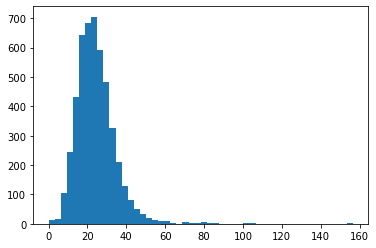

In [346]:
plt.hist(df.SD_pan, bins=50)

Unimodal with a right skew. The values near 0 do not seem to be that eggregious of outliers here, so the outliers we identified before [1482, 1493, 1515, 2813, and to a lesser extent, 1545] are probably major outliers just for GLCM_pan. Now to look at the boxplot.

<AxesSubplot:>

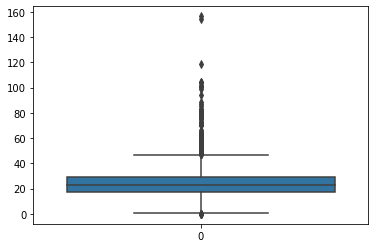

In [347]:
sns.boxplot(data=df.SD_pan)

Values around 0 are outliers, but going to check real quick what happens if we extend the whiskers to 175% of IQR outside of Q3 and Q1, instead of 150%.

<AxesSubplot:>

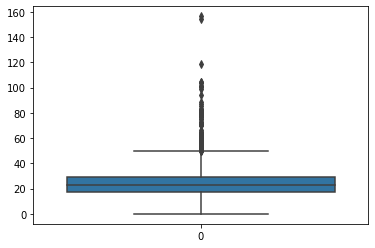

In [348]:
sns.boxplot(data=df.SD_pan,whis=1.75)

Okay, so those values are really not that major of outliers. However, note those values near the top of the plot, above 140, and the other, right around 120. Let's find out what those are.

In [349]:
findSDPanOut=df.query('SD_pan>115')
findSDPanOut

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
3451,n,104.302083,270.000000,146.0,430.0,154.573248
4466,n,114.452381,428.047619,278.0,518.0,118.857105
4691,n,93.979167,543.000000,367.0,396.0,156.508431


The furthest outliers for SD_pan are 3451 and 4691, and the slightly closer one thats still separated is 4466.
Running list of major outliers: [1482, 1493, 1515, 2813, and to a lesser extent, 1545] for GLCM_pan, [3451, 4691, and to a lesser extent, 4466] for SD_pan.
On a positive note, all of the major outliers have been of the 'Not diseased' class (n).

Now to look at Mean_Green in the same way.

(array([1.000e+00, 2.880e+02, 2.247e+03, 1.662e+03, 3.340e+02, 8.700e+01,
        6.900e+01, 4.200e+01, 2.400e+01, 2.100e+01, 2.200e+01, 9.000e+00,
        8.000e+00, 3.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 3.000e+00,
        0.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 117.2105263 ,  151.84464911,  186.47877193,  221.11289474,
         255.74701756,  290.38114037,  325.01526318,  359.649386  ,
         394.28350881,  428.91763163,  463.55175444,  498.18587725,
         532.82000007,  567.45412288,  602.0882457 ,  636.72236851,
         671.35649132,  705.99061414,  740.62473695,  775.25885977,
         809.89298258,  844.52710539

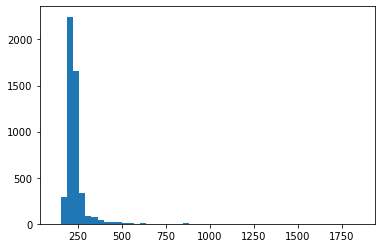

In [350]:
plt.hist(df.Mean_Green, bins=50)

Look how steep that is! The distribution is unimodal, with a right skew.

<AxesSubplot:>

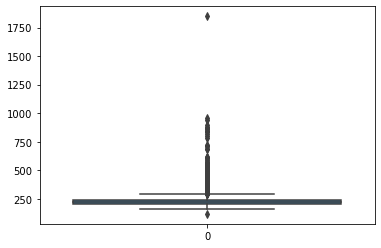

In [351]:
sns.boxplot(data=df.Mean_Green)

Note that really far point. Going to find that first.

In [352]:
findMeanGreenOut=df.query('Mean_Green>1250')
findMeanGreenOut

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
479,n,117.109948,1848.916667,1594.583333,1597.333333,16.612412


That really far outlier in Mean_Green is 479
 Running list of major outliers: [1482, 1493, 1515, 2813, and to a lesser extent, 1545] for GLCM_pan, [3451, 4691, and to a lesser extent, 4466] for SD_pan, and [479] for Mean_Green. On a positive note, all of the major outliers have been of the 'Not diseased' class (n). Going to check the values of the points with Mean_Green>750, and see how many there are and of what class they are.

In [353]:
MGouts=df.query('Mean_Green>750')
MGouts

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
479,n,117.109948,1848.916667,1594.583333,1597.333333,16.612412
1525,n,123.821429,875.714286,727.571429,943.000000,41.887118
1529,n,120.015625,857.500000,710.500000,928.000000,28.044607
1530,n,124.395833,893.333333,746.333333,932.333333,57.434020
1534,n,96.388889,836.777778,675.111111,877.888889,51.103623
1535,n,115.378947,819.916667,639.250000,841.000000,46.060573
1549,n,127.046875,779.000000,601.000000,789.000000,23.413404
1550,n,121.140625,797.000000,608.000000,819.000000,74.878234
4367,n,123.446686,846.874286,653.845714,714.468571,30.958788
4381,n,122.949597,943.451613,736.935484,778.387097,16.664405


In [354]:
len(MGouts)

13

13, all of non-diseased class. None of them have popped up as outliers before. Going to query again, but for Mean_Green>500.

In [355]:
Mouts=df.query('Mean_Green>500')
Mouts

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
479,n,117.109948,1848.916667,1594.583333,1597.333333,16.612412
1338,n,128.025000,559.600000,396.000000,609.800000,23.174124
1339,n,101.300595,534.809524,398.428571,605.952381,27.311838
1344,n,117.990991,502.000000,335.000000,560.000000,22.568716
1518,n,160.894531,609.375000,483.500000,694.937500,27.834051
1525,n,123.821429,875.714286,727.571429,943.000000,41.887118
1529,n,120.015625,857.500000,710.500000,928.000000,28.044607
1530,n,124.395833,893.333333,746.333333,932.333333,57.434020
1531,n,69.545455,710.000000,579.000000,731.000000,0.000000
1532,n,120.862500,688.400000,533.400000,706.400000,45.000444


In [356]:
len(Mouts)

41

Going to keep that for later reference and move onto Mean_Red. Note that they are still all non-diseased.

(array([3.210e+02, 2.961e+03, 1.007e+03, 2.130e+02, 9.500e+01, 7.400e+01,
        3.500e+01, 3.500e+01, 2.500e+01, 1.600e+01, 8.000e+00, 8.000e+00,
        6.000e+00, 3.000e+00, 7.000e+00, 5.000e+00, 3.000e+00, 4.000e+00,
        1.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  50.57894737,   81.45903508,  112.3391228 ,  143.21921051,
         174.09929822,  204.97938593,  235.85947365,  266.73956136,
         297.61964907,  328.49973678,  359.3798245 ,  390.25991221,
         421.13999992,  452.02008763,  482.90017535,  513.78026306,
         544.66035077,  575.54043848,  606.4205262 ,  637.30061391,
         668.18070162,  699.06078933

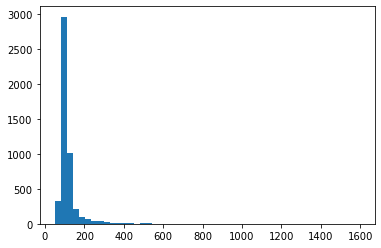

In [357]:
plt.hist(df.Mean_Red, bins=50)

As with Mean_Green, Mean_Red has a very steep unimodal distribution with a right skew.

<AxesSubplot:>

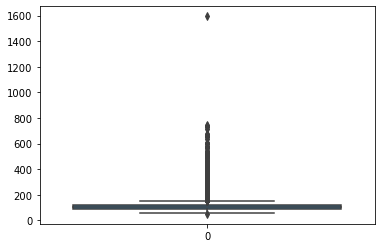

In [358]:
sns.boxplot(data=df.Mean_Red)

Note that very far outlier, near the top. Going to find via a query.

In [359]:
findMeanRedOut=df.query('Mean_Red>1250')
findMeanRedOut

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
479,n,117.109948,1848.916667,1594.583333,1597.333333,16.612412


That major outlier in Mean_Red is 479, the same one as the major outlier in Mean_Green. 
Running list of major outliers: [1482, 1493, 1515, 2813, and to a lesser extent, 1545] for GLCM_pan, [3451, 4691, and to a lesser extent, 4466] for SD_pan, and [479] for Mean_Green and Mean_Red. On a positive note, all of the major outliers have been of the 'Not diseased' class (n). Going to find the outliers of Mean_Red with values >400, check classes, and then check if those overlap with the Mean_Green outliers.

In [360]:
MRouts=df.query('Mean_Red>400')
MRouts

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
479,n,117.109948,1848.916667,1594.583333,1597.333333,16.612412
1518,n,160.894531,609.375000,483.500000,694.937500,27.834051
1525,n,123.821429,875.714286,727.571429,943.000000,41.887118
1529,n,120.015625,857.500000,710.500000,928.000000,28.044607
1530,n,124.395833,893.333333,746.333333,932.333333,57.434020
1531,n,69.545455,710.000000,579.000000,731.000000,0.000000
1532,n,120.862500,688.400000,533.400000,706.400000,45.000444
1534,n,96.388889,836.777778,675.111111,877.888889,51.103623
1535,n,115.378947,819.916667,639.250000,841.000000,46.060573
1536,n,112.250000,686.000000,528.333333,703.666667,43.774676


All non-diseased. Now to check for overlap with the Mean_Green query:

In [361]:
Mouts2=Mouts.query('Mean_Red>400')
Mouts2

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
479,n,117.109948,1848.916667,1594.583333,1597.333333,16.612412
1518,n,160.894531,609.375000,483.500000,694.937500,27.834051
1525,n,123.821429,875.714286,727.571429,943.000000,41.887118
1529,n,120.015625,857.500000,710.500000,928.000000,28.044607
1530,n,124.395833,893.333333,746.333333,932.333333,57.434020
1531,n,69.545455,710.000000,579.000000,731.000000,0.000000
1532,n,120.862500,688.400000,533.400000,706.400000,45.000444
1534,n,96.388889,836.777778,675.111111,877.888889,51.103623
1535,n,115.378947,819.916667,639.250000,841.000000,46.060573
1536,n,112.250000,686.000000,528.333333,703.666667,43.774676


In [362]:
len(Mouts)

41

In [363]:
len(Mouts2)

30

11 of those did not overlap, but 30 did. Keeping in mind for future reference and moving onto Mean_NIR.

(array([  3.,   5.,  18.,  33.,  67.,  93., 111., 148., 228., 249., 297.,
        365., 360., 328., 345., 318., 332., 288., 257., 238., 183., 167.,
        135., 104.,  57.,  46.,  31.,  22.,   5.,   4.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  86.5       ,  116.71666666,  146.93333332,  177.14999998,
         207.36666664,  237.5833333 ,  267.79999996,  298.01666662,
         328.23333328,  358.44999994,  388.6666666 ,  418.88333326,
         449.09999992,  479.31666658,  509.53333324,  539.7499999 ,
         569.96666656,  600.18333322,  630.39999988,  660.61666654,
         690.8333332 ,  721.04999986,  751.26666652,  781.48333318,
         811.69999984,  841.9166665 ,  872.13333316,  902.34999982,
         932.56666648,  962.78333314,  992.9999998 , 1023.21666646,
        1053.43333312, 1083.64999978, 1113.86666644, 1144.0833331 ,
        1174.29999976, 1204.51666642, 1234.733

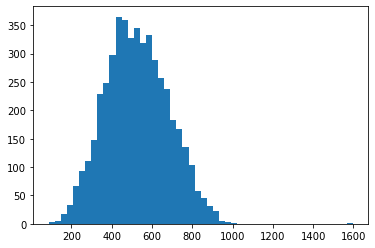

In [364]:
plt.hist(df.Mean_NIR, bins=50)

Mean_NIR has a much different distribution than Mean_Green and Mean_Red did. It may still have a right skew, but that could just be a complete outlier.

<AxesSubplot:>

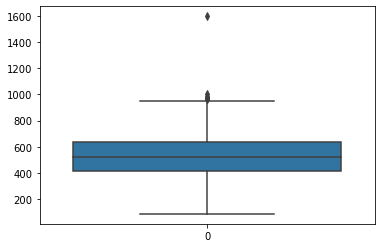

In [365]:
sns.boxplot(data=df.Mean_NIR)

Mean_NIR's 'skew' seems to be mostly a single value near the top of the plot. Going to check its index.

In [366]:
findMeanNIROut=df.query('Mean_NIR>1250')
findMeanNIROut

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
479,n,117.109948,1848.916667,1594.583333,1597.333333,16.612412


The really far outlier was 479, again.  Running list of major outliers: [1482, 1493, 1515, 2813, and to a lesser extent, 1545] for GLCM_pan, [3451, 4691, and to a lesser extent, 4466] for SD_pan, and [479] for Mean_Green, Mean_Red, Mean_NIR. On a positive note, all of the major outliers have been of the 'Not diseased' class (n) Very good case for dropping 479. We're going to tenatively keep the observations in Mouts2, as they do not seem to be major outliers of any other column. 

Since index 479 is an extreme outlier in three different columns, and is of the "not diseased" class (n) which has over 4000 entries, if we kept it in it would have a slight chance of giving the model a slight benefit (since it is just one point out of >4000), and due to its nature as an extreme outlier in several ways, would also have a high chance of causing problems within the model. So, we are going to drop it.

In [367]:
df

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,n,109.828571,183.700000,82.950000,251.750000,16.079412
1,n,130.284483,212.637931,96.896552,482.396552,21.210295
2,n,131.386555,185.466667,85.466667,419.666667,13.339998
3,n,141.345098,180.875000,81.500000,348.062500,18.213577
4,w,121.383408,218.357143,112.017857,426.607143,19.083196
...,...,...,...,...,...,...
4834,n,111.568773,203.588235,93.264706,403.735294,26.512777
4835,n,125.435240,206.394161,93.058394,512.270073,33.466060
4836,n,132.123859,465.343750,295.333333,499.250000,38.762967
4837,n,124.469536,215.152632,98.484211,675.915789,28.506542


In [368]:
df.iloc[479]
removedRow=df.iloc[479] #Saving the row for future reference.
removedRow

class                   n
GLCM_pan       117.109948
Mean_Green    1848.916667
Mean_Red      1594.583333
Mean_NIR      1597.333333
SD_pan          16.612412
Name: 479, dtype: object

In [369]:
df.drop([479],inplace=True)

In [370]:
df

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,n,109.828571,183.700000,82.950000,251.750000,16.079412
1,n,130.284483,212.637931,96.896552,482.396552,21.210295
2,n,131.386555,185.466667,85.466667,419.666667,13.339998
3,n,141.345098,180.875000,81.500000,348.062500,18.213577
4,w,121.383408,218.357143,112.017857,426.607143,19.083196
...,...,...,...,...,...,...
4834,n,111.568773,203.588235,93.264706,403.735294,26.512777
4835,n,125.435240,206.394161,93.058394,512.270073,33.466060
4836,n,132.123859,465.343750,295.333333,499.250000,38.762967
4837,n,124.469536,215.152632,98.484211,675.915789,28.506542


Note that there are now only 4838 observations.

Now, to redo some of those visualizations and summaries now that 479 is gone.

<AxesSubplot:>

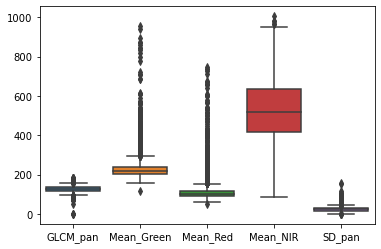

In [371]:
sns.boxplot(data=df)

<AxesSubplot:>

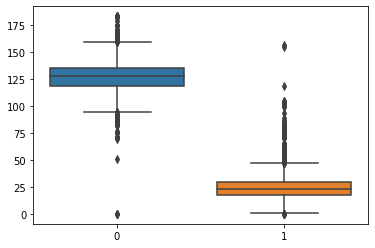

In [372]:
sns.boxplot(data=[df.GLCM_pan,df.SD_pan])

<AxesSubplot:>

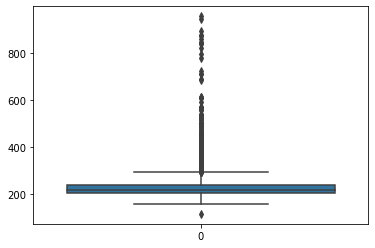

In [373]:
sns.boxplot(data=df.Mean_Green)

<AxesSubplot:>

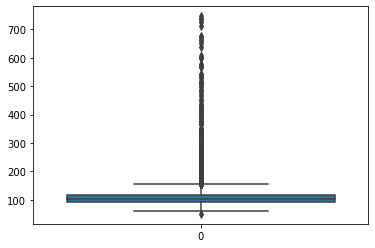

In [374]:
sns.boxplot(data=df.Mean_Red)

<AxesSubplot:>

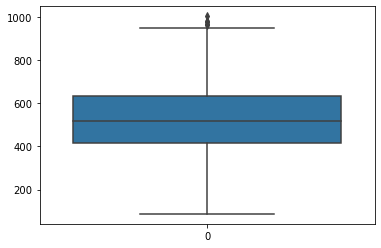

In [375]:
sns.boxplot(data=df.Mean_NIR)

(array([1.000e+00, 0.000e+00, 1.700e+01, 2.120e+02, 7.610e+02, 1.317e+03,
        1.058e+03, 7.090e+02, 3.190e+02, 1.140e+02, 5.700e+01, 4.000e+01,
        4.700e+01, 2.400e+01, 3.000e+01, 1.900e+01, 9.000e+00, 1.500e+01,
        8.000e+00, 1.500e+01, 1.100e+01, 3.000e+00, 1.400e+01, 2.000e+00,
        7.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([117.2105263 , 133.98060149, 150.75067668, 167.52075186,
        184.29082705, 201.06090224, 217.83097743, 234.60105262,
        251.3711278 , 268.14120299, 284.91127818, 301.68135337,
        318.45142856, 335.22150374, 351.99157893, 368.76165412,
        385.53172931, 402.3018045 , 419.07187968, 435.84195487,
        452.61203006, 469.38210525, 486.15218044, 502.92

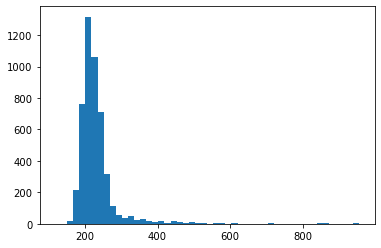

In [376]:
plt.hist(df.Mean_Green, bins=50)

(array([2.000e+00, 1.820e+02, 1.121e+03, 1.533e+03, 9.660e+02, 3.860e+02,
        1.610e+02, 1.020e+02, 5.500e+01, 4.500e+01, 3.800e+01, 4.300e+01,
        2.700e+01, 2.100e+01, 1.400e+01, 2.100e+01, 1.300e+01, 1.300e+01,
        1.300e+01, 1.000e+01, 1.100e+01, 5.000e+00, 5.000e+00, 2.000e+00,
        5.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 4.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00]),
 array([ 50.57894737,  64.49403509,  78.40912281,  92.32421053,
        106.23929824, 120.15438596, 134.06947368, 147.9845614 ,
        161.89964912, 175.81473684, 189.72982456, 203.64491227,
        217.55999999, 231.47508771, 245.39017543, 259.30526315,
        273.22035087, 287.13543859, 301.0505263 , 314.96561402,
        328.88070174, 342.79578946, 356.71087718, 370.62

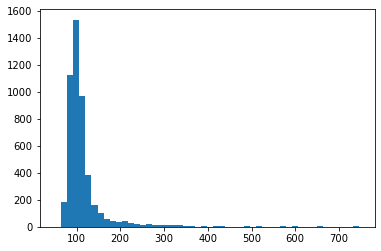

In [377]:
plt.hist(df.Mean_Red, bins=50)

(array([  1.,   2.,   3.,  10.,  11.,  18.,  31.,  42.,  54.,  59.,  61.,
         81.,  97., 137., 130., 143., 184., 170., 212., 234., 215., 201.,
        208., 212., 185., 196., 202., 209., 177., 169., 158., 148., 136.,
        107., 115., 102.,  88.,  71.,  67.,  51.,  29.,  34.,  22.,  21.,
          9.,  15.,   5.,   3.,   2.,   1.]),
 array([  86.5       ,  104.88032258,  123.26064516,  141.64096774,
         160.02129032,  178.4016129 ,  196.78193548,  215.16225806,
         233.54258064,  251.92290322,  270.3032258 ,  288.68354838,
         307.06387096,  325.44419354,  343.82451612,  362.2048387 ,
         380.58516128,  398.96548386,  417.34580644,  435.72612902,
         454.1064516 ,  472.48677418,  490.86709676,  509.24741934,
         527.62774192,  546.0080645 ,  564.38838708,  582.76870966,
         601.14903224,  619.52935482,  637.9096774 ,  656.28999998,
         674.67032256,  693.05064514,  711.43096772,  729.8112903 ,
         748.19161288,  766.57193546,  784.952

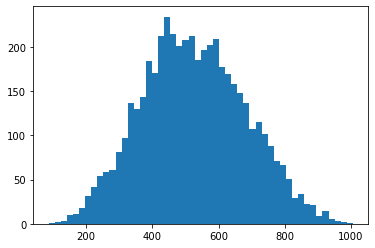

In [378]:
plt.hist(df.Mean_NIR, bins=50)

We are going to temporarily replace the values 'n' and 'w' in df.class with 'not' and 'sickTree', respectively.

In [379]:
df['class'].groupby(df['class']).count()

class
n    4577
w     261
Name: class, dtype: int64

In [380]:
df.loc[df["class"]== 'n',"class"] = "not"
df.loc[df["class"]== 'w',"class"] = "sickTree"

In [381]:
df['class'].groupby(df['class']).count()

class
not         4577
sickTree     261
Name: class, dtype: int64

In [382]:
df

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,not,109.828571,183.700000,82.950000,251.750000,16.079412
1,not,130.284483,212.637931,96.896552,482.396552,21.210295
2,not,131.386555,185.466667,85.466667,419.666667,13.339998
3,not,141.345098,180.875000,81.500000,348.062500,18.213577
4,sickTree,121.383408,218.357143,112.017857,426.607143,19.083196
...,...,...,...,...,...,...
4834,not,111.568773,203.588235,93.264706,403.735294,26.512777
4835,not,125.435240,206.394161,93.058394,512.270073,33.466060
4836,not,132.123859,465.343750,295.333333,499.250000,38.762967
4837,not,124.469536,215.152632,98.484211,675.915789,28.506542


Going to run an SNS pairplot to see how the values vary by class, which could help us determine what models may be most effective.

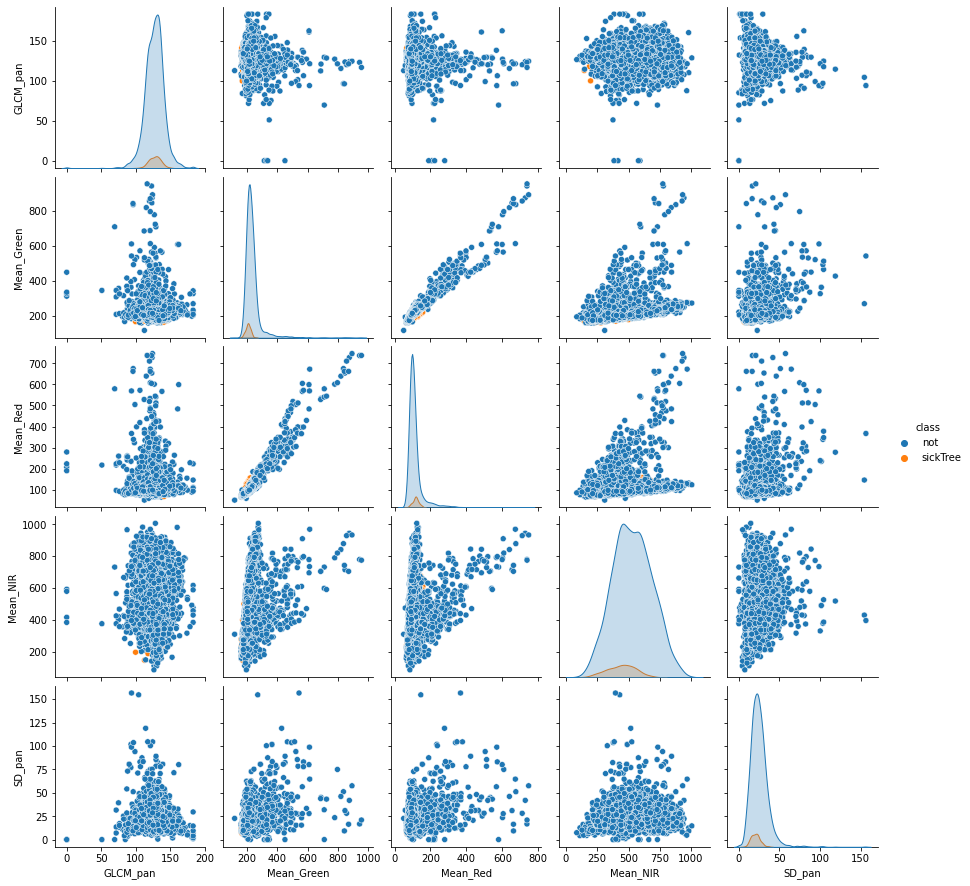

In [383]:
sns.pairplot(df[['GLCM_pan','Mean_Green','Mean_Red','Mean_NIR','SD_pan','class']], hue='class')

Something that may pose a big of a problem-- the 'not' observations' values seem to envelop the 'sickTree' observations' values in most of these pairplots. Going to quickly look at the Means together, and then going to see what these pairplots look like with just the 'sickTree' class observations (and then perhaps some more visualizations of that class.)

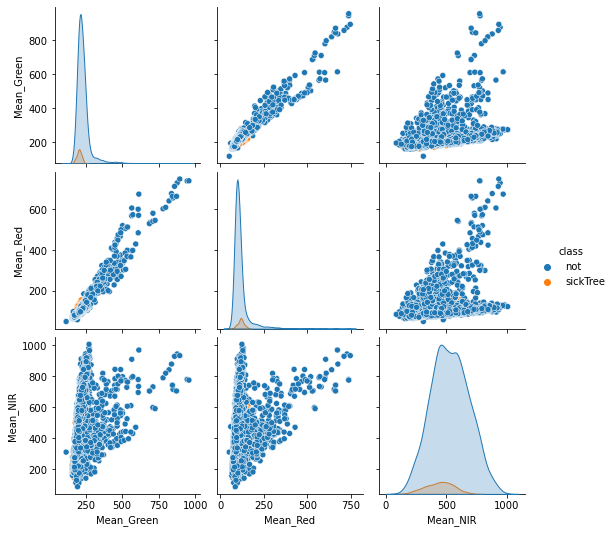

In [384]:
sns.pairplot(df[['Mean_Green','Mean_Red','Mean_NIR','class']], hue='class')

Some problems are being caused because of the name of the class column. Going to change it to Class, then get back to looking at visualizations.

In [385]:
df.columns

Index(['class', 'GLCM_pan', 'Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan'], dtype='object')

In [386]:
oldNames=df.columns
newNames=['Class', 'GLCM_pan', 'Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan']
df.columns=newNames
df.columns

Index(['Class', 'GLCM_pan', 'Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan'], dtype='object')

In [387]:
df

,Class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,not,109.828571,183.700000,82.950000,251.750000,16.079412
1,not,130.284483,212.637931,96.896552,482.396552,21.210295
2,not,131.386555,185.466667,85.466667,419.666667,13.339998
3,not,141.345098,180.875000,81.500000,348.062500,18.213577
4,sickTree,121.383408,218.357143,112.017857,426.607143,19.083196
...,...,...,...,...,...,...
4834,not,111.568773,203.588235,93.264706,403.735294,26.512777
4835,not,125.435240,206.394161,93.058394,512.270073,33.466060
4836,not,132.123859,465.343750,295.333333,499.250000,38.762967
4837,not,124.469536,215.152632,98.484211,675.915789,28.506542


Done. Now back to visualizations.

In [388]:
dfSick=df.query('Class=="sickTree"')
dfSick

,Class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
4,sickTree,121.383408,218.357143,112.017857,426.607143,19.083196
6,sickTree,124.010204,215.594595,117.027027,477.297297,24.574628
7,sickTree,125.608407,209.649123,121.228070,443.280702,25.757314
16,sickTree,116.948953,214.562500,127.750000,390.208333,23.070506
17,sickTree,116.948953,214.562500,127.750000,390.208333,23.070506
...,...,...,...,...,...,...
569,sickTree,141.574230,199.244444,127.333333,364.177778,15.219286
570,sickTree,127.218812,190.314961,110.102362,383.393701,19.666454
571,sickTree,118.122585,217.894118,134.235294,443.111765,18.376031
572,sickTree,138.614314,213.603175,126.111111,421.000000,18.304925


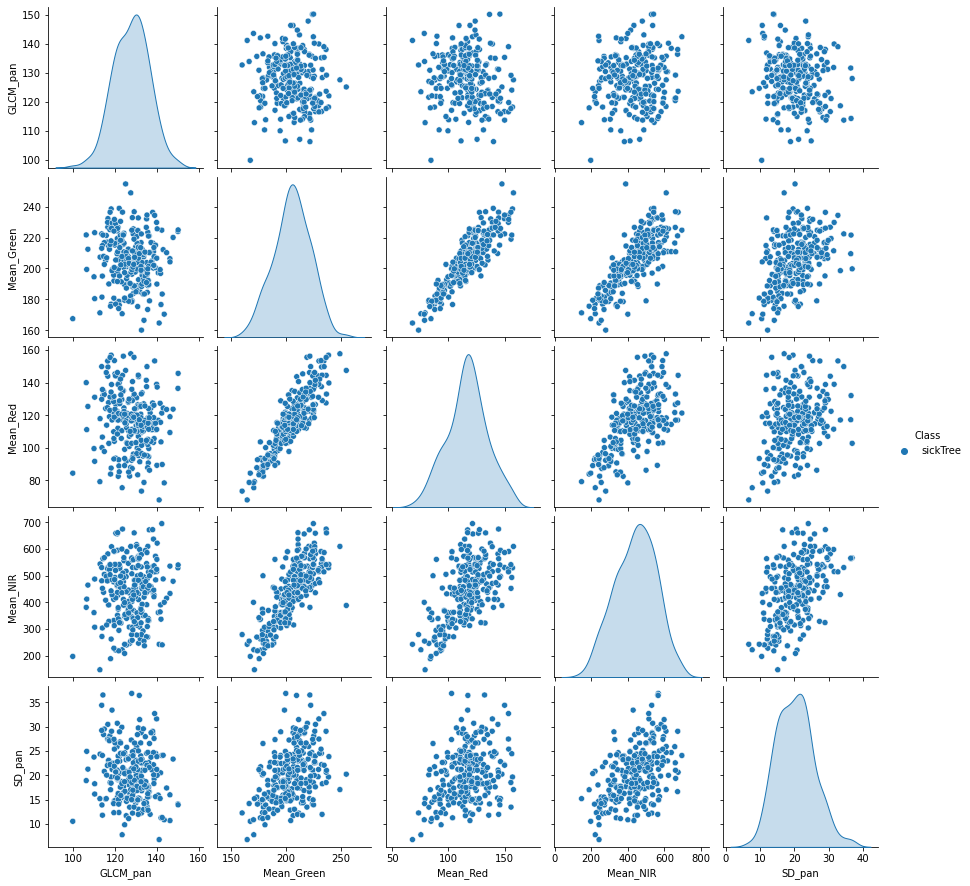

In [322]:
sns.pairplot(dfSick[['GLCM_pan','Mean_Green','Mean_Red','Mean_NIR','SD_pan','Class']], hue='Class')

It may be worth looking into some of the differences between the full dataset, the sickTree observations, and the not observations. Going to do so.

In [323]:
dfNot=df.query('Class=="not"')
dfNot

,Class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,not,109.828571,183.700000,82.950000,251.750000,16.079412
1,not,130.284483,212.637931,96.896552,482.396552,21.210295
2,not,131.386555,185.466667,85.466667,419.666667,13.339998
3,not,141.345098,180.875000,81.500000,348.062500,18.213577
5,not,122.757576,205.960000,86.760000,407.680000,17.823580
...,...,...,...,...,...,...
4834,not,111.568773,203.588235,93.264706,403.735294,26.512777
4835,not,125.435240,206.394161,93.058394,512.270073,33.466060
4836,not,132.123859,465.343750,295.333333,499.250000,38.762967
4837,not,124.469536,215.152632,98.484211,675.915789,28.506542


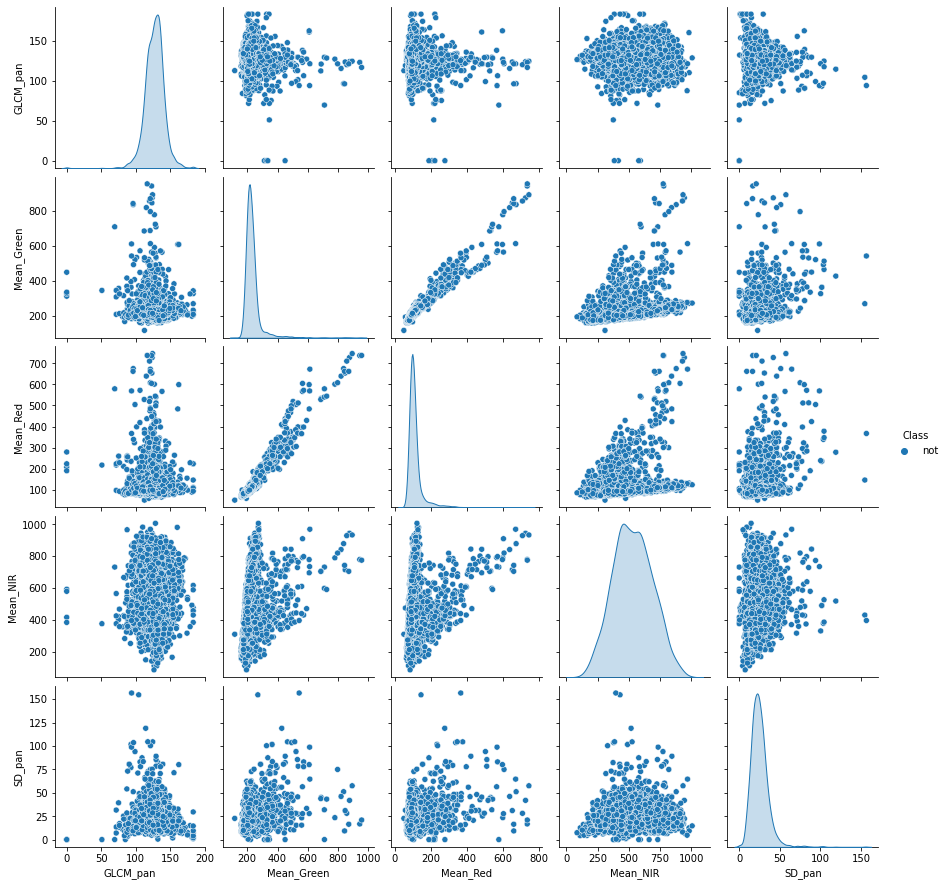

In [240]:
sns.pairplot(dfNot[['GLCM_pan','Mean_Green','Mean_Red','Mean_NIR','SD_pan','Class']], hue='Class')

In [241]:
df.describe()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
count,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000
mean,126.857561,231.078325,115.999776,525.578818,24.483634
std,13.451176,58.841068,58.254692,155.835557,10.727509
min,0.000000,117.210526,50.578947,86.500000,0.000000
25%,118.776184,203.894643,91.521466,415.441472,17.684386
50%,127.482533,219.260870,101.629515,518.495238,23.198874
75%,134.947889,239.846154,116.963268,635.111538,29.328327
max,183.281250,955.714286,746.333333,1005.516129,156.508431


In [242]:
dfNot.describe()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
count,4577.000000,4577.000000,4577.000000,4577.000000,4577.000000
mean,126.809874,232.549245,115.968808,530.396381,24.721706
std,13.679032,60.031244,59.743093,156.645516,10.904041
min,0.000000,117.210526,50.578947,86.500000,0.000000
25%,118.536023,204.714286,91.250000,418.494382,17.804016
50%,127.437819,220.555556,100.684211,524.729730,23.406588
75%,135.059289,241.333333,115.833333,641.102041,29.677077
max,183.281250,955.714286,746.333333,1005.516129,156.508431


As expected (since the vast majority of the observations are of the 'not' class), when there are differences in the basic statistics of the full dataset and the dataset that only has observations that are not diseased trees, they are very minor (ignoring count, of course.)

In [243]:
dfSick.describe()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
count,261.000000,261.000000,261.000000,261.000000,261.000000
mean,127.693820,205.283692,116.542842,441.096116,20.308693
std,8.490524,16.719662,17.756550,111.131804,5.460654
min,99.812500,160.029412,68.000000,146.777778,6.753471
25%,121.506731,195.055556,105.208333,361.321429,15.973489
50%,128.216868,205.557252,117.000000,448.071429,20.139100
75%,133.532538,216.500000,127.333333,527.258621,23.747187
max,150.181035,254.812500,157.722772,695.750000,36.859319


##### For the dataset of sick trees, most of the basic statistics are far off from the full dataset and the dfNot dataframe. 
##### The mean of GLCM_pan is strickingly similar across all the datasets, and so is the mean of Mean_Red. The rest of the columns of dfSick have noticably different mean values from df and dfNot.
##### Although all of the columns of dfSick have noticeably different standard deviations from the other two dataframes, it is worth noting just how different the standard deviations for Mean_Green and Mean_Red are-- from about 60 t0 ~17, and from about 59 to ~18. This is especially noteable as Mean_Red's mean was not that different between the three datasets.
##### The minimum values, as expected, changed. GLCM_pan changed the most drastically, but that was expected from our earlier investigation of GLCM_pan's outlier values.
##### Mean_NIR has a very dramatic difference for quartile values when comparing dfSick to the others-- Q1 goes from ~416 to 361, Q2 goes from ~520 to 448, and Q3 goes from ~640 to 527 (with the first value being approximately the values for df and dfNot, and the second values being dfSick)
##### The maximum values also had a significant shift-- not surprising, given our earlier investigation of outliers. 

<AxesSubplot:>

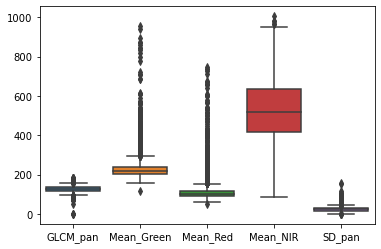

In [244]:
sns.boxplot(data=df)

<AxesSubplot:>

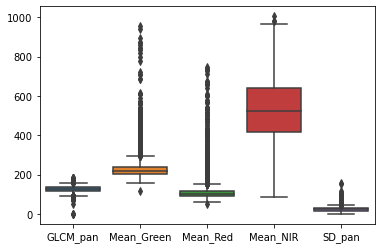

In [245]:
sns.boxplot(data=dfNot)

Barely any change from df to dfNot, as expected.

<AxesSubplot:>

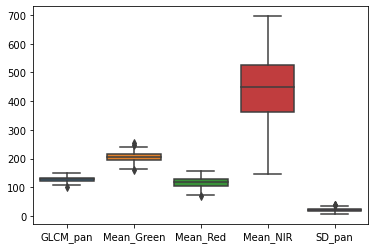

In [246]:
sns.boxplot(data=dfSick)

As expected, a major difference between the other two and dfSick. Going to look at each of these in closer detail.

Having some trouble with getting a boxplot of dfSick.GLCM_pan, though I am not getting any errors for dfNot and df. plt.boxplot works, however.

In [247]:
#sns.boxplot(data=dfSick.GLCM_pan)

<AxesSubplot:ylabel='Value'>

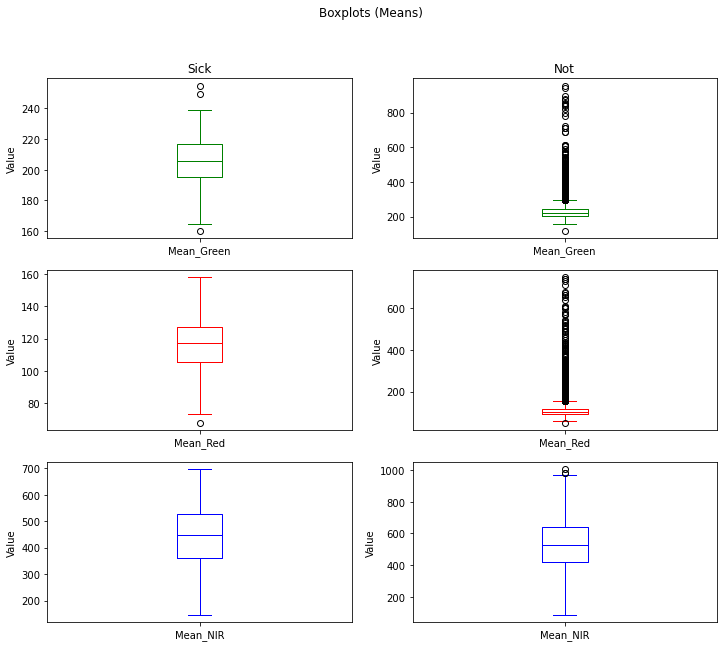

In [248]:
fig, axes = plt.subplots(3,2, figsize=(12,10))
fig.suptitle('Boxplots (Means)')
dfSick.Mean_Green.plot(kind='box',xlabel='Mean_Green',ylabel='Value', title='Sick',color='green',legend=False,ax=axes[0,0])
dfNot.Mean_Green.plot(kind='box',xlabel='Mean_Green',ylabel='Value',title='Not',color='green',legend=False,ax=axes[0,1])
dfSick.Mean_Red.plot(kind='box',xlabel='Mean_Red',ylabel='Value',color='red',legend=False,ax=axes[1,0])
dfNot.Mean_Red.plot(kind='box',xlabel='Mean_Red',ylabel='Value',color='red',legend=False,ax=axes[1,1])
dfSick.Mean_NIR.plot(kind='box',xlabel='Mean_NIR',ylabel='Value',color='blue',legend=False,ax=axes[2,0])
dfNot.Mean_NIR.plot(kind='box',xlabel='Mean_NIR',ylabel='Value',color='blue',legend=False,ax=axes[2,1])

<AxesSubplot:ylabel='Value'>

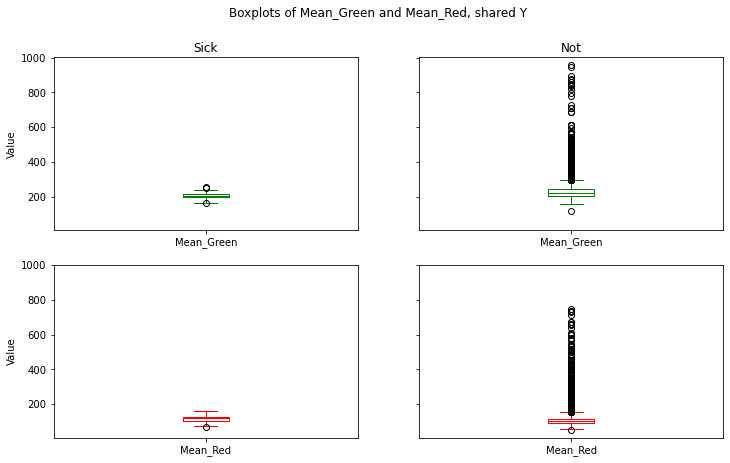

In [249]:
fig, axes = plt.subplots(2,2, figsize=(12,7),sharey=True)
fig.suptitle('Boxplots of Mean_Green and Mean_Red, shared Y')
dfSick.Mean_Green.plot(kind='box',xlabel='Mean_Green',ylabel='Value', title='Sick',color='green',legend=False,ax=axes[0,0])
dfNot.Mean_Green.plot(kind='box',xlabel='Mean_Green',ylabel='Value',title='Not',color='green',legend=False,ax=axes[0,1])
dfSick.Mean_Red.plot(kind='box',xlabel='Mean_Red',ylabel='Value',color='red',legend=False,ax=axes[1,0])
dfNot.Mean_Red.plot(kind='box',xlabel='Mean_Red',ylabel='Value',color='red',legend=False,ax=axes[1,1])

<AxesSubplot:title={'center':'Not'}, ylabel='Value'>

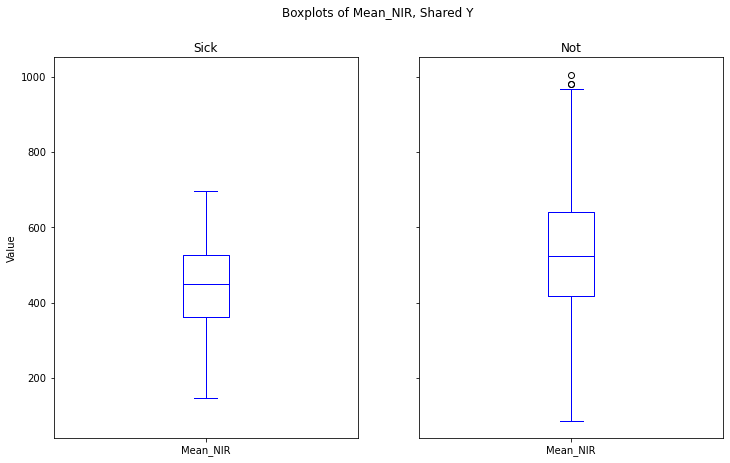

In [250]:
fig, axes = plt.subplots(1,2, figsize=(12,7),sharey=True)
fig.suptitle('Boxplots of Mean_NIR, Shared Y')
dfSick.Mean_NIR.plot(kind='box',xlabel='Mean_NIR',ylabel='Value',color='blue',title='Sick',legend=False,ax=axes[0])
dfNot.Mean_NIR.plot(kind='box',xlabel='Mean_NIR',ylabel='Value',color='blue',title='Not',legend=False,ax=axes[1])

## Going to very quickly mess around with some logistic regression, will have to redo later with test and verification sets and all that. Just experimenting.

In [389]:
df

,Class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,not,109.828571,183.700000,82.950000,251.750000,16.079412
1,not,130.284483,212.637931,96.896552,482.396552,21.210295
2,not,131.386555,185.466667,85.466667,419.666667,13.339998
3,not,141.345098,180.875000,81.500000,348.062500,18.213577
4,sickTree,121.383408,218.357143,112.017857,426.607143,19.083196
...,...,...,...,...,...,...
4834,not,111.568773,203.588235,93.264706,403.735294,26.512777
4835,not,125.435240,206.394161,93.058394,512.270073,33.466060
4836,not,132.123859,465.343750,295.333333,499.250000,38.762967
4837,not,124.469536,215.152632,98.484211,675.915789,28.506542


In [390]:
dfBackup=df.copy()

In [391]:
dfBackup

,Class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,not,109.828571,183.700000,82.950000,251.750000,16.079412
1,not,130.284483,212.637931,96.896552,482.396552,21.210295
2,not,131.386555,185.466667,85.466667,419.666667,13.339998
3,not,141.345098,180.875000,81.500000,348.062500,18.213577
4,sickTree,121.383408,218.357143,112.017857,426.607143,19.083196
...,...,...,...,...,...,...
4834,not,111.568773,203.588235,93.264706,403.735294,26.512777
4835,not,125.435240,206.394161,93.058394,512.270073,33.466060
4836,not,132.123859,465.343750,295.333333,499.250000,38.762967
4837,not,124.469536,215.152632,98.484211,675.915789,28.506542


In [392]:
y=df.Class
y.replace('sickTree',1,inplace=True)
y.replace('not',0,inplace=True)
y = np.array(y)

In [395]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4838 entries, 0 to 4838
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Class       4838 non-null   int64  
 1   GLCM_pan    4838 non-null   float64
 2   Mean_Green  4838 non-null   float64
 3   Mean_Red    4838 non-null   float64
 4   Mean_NIR    4838 non-null   float64
 5   SD_pan      4838 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 393.6 KB


In [415]:
X=df.iloc[:,1:]
X

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,109.828571,183.700000,82.950000,251.750000,16.079412
1,130.284483,212.637931,96.896552,482.396552,21.210295
2,131.386555,185.466667,85.466667,419.666667,13.339998
3,141.345098,180.875000,81.500000,348.062500,18.213577
4,121.383408,218.357143,112.017857,426.607143,19.083196
...,...,...,...,...,...
4834,111.568773,203.588235,93.264706,403.735294,26.512777
4835,125.435240,206.394161,93.058394,512.270073,33.466060
4836,132.123859,465.343750,295.333333,499.250000,38.762967
4837,124.469536,215.152632,98.484211,675.915789,28.506542


In [416]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X,y)

In [417]:
clf.predict(X)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [418]:
clf.score(X,y) #with all numerical columns

0.9681686647374949

With just means

In [402]:
X=df.iloc[:,2:5]
X

,Mean_Green,Mean_Red,Mean_NIR
0,183.700000,82.950000,251.750000
1,212.637931,96.896552,482.396552
2,185.466667,85.466667,419.666667
3,180.875000,81.500000,348.062500
4,218.357143,112.017857,426.607143
...,...,...,...
4834,203.588235,93.264706,403.735294
4835,206.394161,93.058394,512.270073
4836,465.343750,295.333333,499.250000
4837,215.152632,98.484211,675.915789


In [403]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X,y)
clf.predict(X)
clf.score(X,y)

0.9681686647374949

Next to nothing changed

With just pans

In [404]:
X=df[['GLCM_pan','SD_pan']]
X

,GLCM_pan,SD_pan
0,109.828571,16.079412
1,130.284483,21.210295
2,131.386555,13.339998
3,141.345098,18.213577
4,121.383408,19.083196
...,...,...
4834,111.568773,26.512777
4835,125.435240,33.466060
4836,132.123859,38.762967
4837,124.469536,28.506542


In [405]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X,y)
clf.predict(X)
clf.score(X,y)

0.9460520876395204

In [422]:
df.columns

Index(['Class', 'GLCM_pan', 'Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan'], dtype='object')

In [423]:
numcols=['GLCM_pan', 'Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan']

In [435]:
print(clf.score(X,y))

0.9460520876395204


In [477]:
#nabbed from internet, https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset by Blake
#take out print statements when not figuring things out
def powerset(x):
    m=[]
    if not x:  #if not [LIST}: executes following if list is empty.
        m.append(x)
        #print("if not x", 'm=',m)
    else:
        A = x[0]
        B = x[1:]
        #print('Right before for loop:   ','m=',m,'  A=',A,'  B=',B,'   r=')
        for z in powerset(B):
            m.append(z)
            r = [A] + z
            m.append(r)
            #print('For loop:   ','m=',m,'  A=',A,'  B=',B,'   r=',r)
    return m

powerset([1,2,3])

[[], [1], [2], [1, 2], [3], [1, 3], [2, 3], [1, 2, 3]]

In [478]:
Power=powerset(numcols)
combos=Power[1:]

In [479]:
combos

[['GLCM_pan'],
 ['Mean_Green'],
 ['GLCM_pan', 'Mean_Green'],
 ['Mean_Red'],
 ['GLCM_pan', 'Mean_Red'],
 ['Mean_Green', 'Mean_Red'],
 ['GLCM_pan', 'Mean_Green', 'Mean_Red'],
 ['Mean_NIR'],
 ['GLCM_pan', 'Mean_NIR'],
 ['Mean_Green', 'Mean_NIR'],
 ['GLCM_pan', 'Mean_Green', 'Mean_NIR'],
 ['Mean_Red', 'Mean_NIR'],
 ['GLCM_pan', 'Mean_Red', 'Mean_NIR'],
 ['Mean_Green', 'Mean_Red', 'Mean_NIR'],
 ['GLCM_pan', 'Mean_Green', 'Mean_Red', 'Mean_NIR'],
 ['SD_pan'],
 ['GLCM_pan', 'SD_pan'],
 ['Mean_Green', 'SD_pan'],
 ['GLCM_pan', 'Mean_Green', 'SD_pan'],
 ['Mean_Red', 'SD_pan'],
 ['GLCM_pan', 'Mean_Red', 'SD_pan'],
 ['Mean_Green', 'Mean_Red', 'SD_pan'],
 ['GLCM_pan', 'Mean_Green', 'Mean_Red', 'SD_pan'],
 ['Mean_NIR', 'SD_pan'],
 ['GLCM_pan', 'Mean_NIR', 'SD_pan'],
 ['Mean_Green', 'Mean_NIR', 'SD_pan'],
 ['GLCM_pan', 'Mean_Green', 'Mean_NIR', 'SD_pan'],
 ['Mean_Red', 'Mean_NIR', 'SD_pan'],
 ['GLCM_pan', 'Mean_Red', 'Mean_NIR', 'SD_pan'],
 ['Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan'],
 ['GLCM_pa

In [480]:
for Combin in combos:
    X=df[Combin]
    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X,y)
    clf.predict(X)
    clf.score(X,y)
    Score=clf.score(X,y)
    print(f'Columns: {Combin}      Score: {Score:.4f}')
    print()

Columns: ['GLCM_pan']      Score: 0.9461

Columns: ['Mean_Green']      Score: 0.9458

Columns: ['GLCM_pan', 'Mean_Green']      Score: 0.9458

Columns: ['Mean_Red']      Score: 0.9461

Columns: ['GLCM_pan', 'Mean_Red']      Score: 0.9461

Columns: ['Mean_Green', 'Mean_Red']      Score: 0.9605

Columns: ['GLCM_pan', 'Mean_Green', 'Mean_Red']      Score: 0.9603

Columns: ['Mean_NIR']      Score: 0.9461

Columns: ['GLCM_pan', 'Mean_NIR']      Score: 0.9461

Columns: ['Mean_Green', 'Mean_NIR']      Score: 0.9461

Columns: ['GLCM_pan', 'Mean_Green', 'Mean_NIR']      Score: 0.9461

Columns: ['Mean_Red', 'Mean_NIR']      Score: 0.9461

Columns: ['GLCM_pan', 'Mean_Red', 'Mean_NIR']      Score: 0.9461

Columns: ['Mean_Green', 'Mean_Red', 'Mean_NIR']      Score: 0.9682

Columns: ['GLCM_pan', 'Mean_Green', 'Mean_Red', 'Mean_NIR']      Score: 0.9682

Columns: ['SD_pan']      Score: 0.9461

Columns: ['GLCM_pan', 'SD_pan']      Score: 0.9461

Columns: ['Mean_Green', 'SD_pan']      Score: 0.9461

Colu

In [481]:
for Combin in combos:
    X=df[Combin]
    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X,y)
    clf.predict(X)
    clf.score(X,y)
    Score=clf.score(X,y)
    if Score>.96:
        print(f'Columns: {Combin}      Score: {Score:.4f}')
        print()

Columns: ['Mean_Green', 'Mean_Red']      Score: 0.9605

Columns: ['GLCM_pan', 'Mean_Green', 'Mean_Red']      Score: 0.9603

Columns: ['Mean_Green', 'Mean_Red', 'Mean_NIR']      Score: 0.9682

Columns: ['GLCM_pan', 'Mean_Green', 'Mean_Red', 'Mean_NIR']      Score: 0.9682

Columns: ['Mean_Green', 'Mean_Red', 'SD_pan']      Score: 0.9605

Columns: ['GLCM_pan', 'Mean_Green', 'Mean_Red', 'SD_pan']      Score: 0.9603

Columns: ['Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan']      Score: 0.9682

Columns: ['GLCM_pan', 'Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan']      Score: 0.9682



In [482]:
for Combin in combos:
    X=df[Combin]
    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X,y)
    clf.predict(X)
    clf.score(X,y)
    Score=clf.score(X,y)
    if Score>.968:
        print(f'Columns: {Combin}      Score: {Score}')
        print()

Columns: ['Mean_Green', 'Mean_Red', 'Mean_NIR']      Score: 0.9681686647374949

Columns: ['GLCM_pan', 'Mean_Green', 'Mean_Red', 'Mean_NIR']      Score: 0.9681686647374949

Columns: ['Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan']      Score: 0.9681686647374949

Columns: ['GLCM_pan', 'Mean_Green', 'Mean_Red', 'Mean_NIR', 'SD_pan']      Score: 0.9681686647374949



### All of the above column combinations are equally as good for predicting if diseased tree.

In [483]:
for Combin in combos:
    X=df[Combin]
    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X,y)
    clf.predict(X)
    clf.score(X,y)
    Score=clf.score(X,y)
    if Score<.95:
        print(f'Columns: {Combin}      Score: {Score:.4f}')
        print()

Columns: ['GLCM_pan']      Score: 0.9461

Columns: ['Mean_Green']      Score: 0.9458

Columns: ['GLCM_pan', 'Mean_Green']      Score: 0.9458

Columns: ['Mean_Red']      Score: 0.9461

Columns: ['GLCM_pan', 'Mean_Red']      Score: 0.9461

Columns: ['Mean_NIR']      Score: 0.9461

Columns: ['GLCM_pan', 'Mean_NIR']      Score: 0.9461

Columns: ['Mean_Green', 'Mean_NIR']      Score: 0.9461

Columns: ['GLCM_pan', 'Mean_Green', 'Mean_NIR']      Score: 0.9461

Columns: ['Mean_Red', 'Mean_NIR']      Score: 0.9461

Columns: ['GLCM_pan', 'Mean_Red', 'Mean_NIR']      Score: 0.9461

Columns: ['SD_pan']      Score: 0.9461

Columns: ['GLCM_pan', 'SD_pan']      Score: 0.9461

Columns: ['Mean_Green', 'SD_pan']      Score: 0.9461

Columns: ['GLCM_pan', 'Mean_Green', 'SD_pan']      Score: 0.9461

Columns: ['Mean_Red', 'SD_pan']      Score: 0.9461

Columns: ['GLCM_pan', 'Mean_Red', 'SD_pan']      Score: 0.9461

Columns: ['Mean_NIR', 'SD_pan']      Score: 0.9461

Columns: ['GLCM_pan', 'Mean_NIR', 'SD_pan'

In [485]:
for Combin in combos:
    X=df[Combin]
    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X,y)
    clf.predict(X)
    clf.score(X,y)
    Score=clf.score(X,y)
    if Score<.946:
        print(f'Columns: {Combin}      Score: {Score}')
        print()

Columns: ['Mean_Green']      Score: 0.9458453906572964

Columns: ['GLCM_pan', 'Mean_Green']      Score: 0.9458453906572964



## These two above column combinations are the worst for prediction. Still pretty good.